## **NYC Taxi Demand Forecasting** ##

**Institution:** The University of Western Ontario  
**Course:** AISE 4010A - Deep Learning for Time Series Data  
**Instructor:** Soodeh Nikan

**Group Members:**
* Ahmed El Shareif - 251199128
* Evan Kale Romano - 251327329
* Joseph Dominique Toma - 251283541
* Mohammed Alamen Qassab - 251285296

Our project is going to use the 2023 NYC Yellow Taxi Trip dataset to forecast taxi demand across different zones and times in New York City. The dataset comprises over 38 million trips, including details such as pickup and drop-off timestamps, locations, distances, passenger counts, and fares. By applying deep learning models, we aim to capture demand patterns and predict future ride volumes. 

### **Data Import and Initial Setup** ###

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import requests
import warnings
warnings.filterwarnings('ignore')

# Configure pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [2]:
# NYC Open Data API configuration for 2023 Yellow Taxi data
# Using SODA2 API with CSV format
import_url = "https://data.cityofnewyork.us/resource/4b4i-vvec.csv"

# Load larger sample for better representation across days/weeks
sample_size = 500000  # Increased from 50,000 to 500,000
api_url = f"{import_url}?$limit={sample_size}"

print(f"Loading {sample_size:,} records from NYC Open Data API...")
df_sample = pd.read_csv(api_url)
print(f"Loaded sample: {df_sample.shape[0]:,} rows, {df_sample.shape[1]} columns")
print(f"Memory usage: {df_sample.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

# Display basic information about the dataset
print("\nColumn names and types:")
print(df_sample.dtypes)

# Check date range in the loaded data
df_sample['tpep_pickup_datetime'] = pd.to_datetime(df_sample['tpep_pickup_datetime'])
print(f"\nDate range in sample:")
print(f"From: {df_sample['tpep_pickup_datetime'].min()}")
print(f"To: {df_sample['tpep_pickup_datetime'].max()}")
print(f"Number of unique days: {df_sample['tpep_pickup_datetime'].dt.date.nunique()}")

Loading 500,000 records from NYC Open Data API...
Loaded sample: 500,000 rows, 19 columns
Loaded sample: 500,000 rows, 19 columns
Memory usage: 153.5 MB

Column names and types:
vendorid                   int64
tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count          float64
trip_distance            float64
ratecodeid               float64
store_and_fwd_flag        object
pulocationid               int64
dolocationid               int64
payment_type               int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
congestion_surcharge     float64
airport_fee              float64
dtype: object

Date range in sample:
From: 2008-12-31 23:04:41
To: 2023-01-07 03:40:12
Number of unique days: 11
Memory usage: 153.5 MB

Column names and types:
vendorid                   int64
t

### **Data Preprocessing and Column Selection** ###

In [3]:
# Define columns relevant for demand forecasting
relevant_columns = [
    'tpep_pickup_datetime', 'tpep_dropoff_datetime', 
    'passenger_count', 'trip_distance', 
    'pulocationid', 'dolocationid', 'fare_amount'
]

# Columns to remove which are not needed for demand prediction
columns_to_drop = [
    'vendorid', 'ratecodeid', 'store_and_fwd_flag', 
    'payment_type', 'extra', 'mta_tax', 'tip_amount',
    'tolls_amount', 'improvement_surcharge', 'total_amount',
    'congestion_surcharge', 'airport_fee'
]

# Select only relevant columns
df_clean = df_sample[relevant_columns].copy()

# Display first few rows and basic statistics
print("Selected columns for analysis:")
print(df_clean.columns.tolist())
print(f"\nDataset shape after column selection: {df_clean.shape}")
df_clean.head()

Selected columns for analysis:
['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'pulocationid', 'dolocationid', 'fare_amount']

Dataset shape after column selection: (500000, 7)


,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pulocationid,dolocationid,fare_amount
0,2023-01-01 00:32:10,2023-01-01T00:40:36.000,1.0,0.97,161,141,9.3
1,2023-01-01 00:55:08,2023-01-01T01:01:27.000,1.0,1.10,43,237,7.9
2,2023-01-01 00:25:04,2023-01-01T00:37:49.000,1.0,2.51,48,238,14.9
3,2023-01-01 00:03:48,2023-01-01T00:13:25.000,0.0,1.90,138,7,12.1
4,2023-01-01 00:10:29,2023-01-01T00:21:19.000,1.0,1.43,107,79,11.4


In [4]:
# Convert datetime columns and handle data quality issues
df_clean['tpep_pickup_datetime'] = pd.to_datetime(df_clean['tpep_pickup_datetime'])
df_clean['tpep_dropoff_datetime'] = pd.to_datetime(df_clean['tpep_dropoff_datetime'])

# Remove records with missing essential data
initial_count = len(df_clean)
df_clean = df_clean.dropna(subset=['tpep_pickup_datetime', 'pulocationid'])

# Filter out invalid trip distances and passenger counts
df_clean = df_clean[
    (df_clean['trip_distance'] > 0) & 
    (df_clean['trip_distance'] < 500) &  
    (df_clean['passenger_count'] > 0) & 
    (df_clean['passenger_count'] <= 6)   
]

# Calculate trip duration in minutes
df_clean['trip_duration_minutes'] = (
    df_clean['tpep_dropoff_datetime'] - df_clean['tpep_pickup_datetime']
).dt.total_seconds() / 60

# Remove trips with unrealistic durations
df_clean = df_clean[
    (df_clean['trip_duration_minutes'] > 1) & 
    (df_clean['trip_duration_minutes'] < 300)  
]

print(f"Data cleaning results:")
print(f"Initial records: {initial_count:,}")
print(f"After cleaning: {len(df_clean):,}")
print(f"Records removed: {initial_count - len(df_clean):,} ({(initial_count - len(df_clean))/initial_count*100:.1f}%)")

# Basic statistics of cleaned data
print(f"\nCleaned dataset summary:")
df_clean.describe()

Data cleaning results:
Initial records: 500,000
After cleaning: 482,172
Records removed: 17,828 (3.6%)

Cleaned dataset summary:


,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pulocationid,dolocationid,fare_amount,trip_duration_minutes
count,482172,482172,482172.000000,482172.000000,482172.000000,482172.00000,482172.000000,482172.000000
mean,2023-01-04 06:41:07.625010688,2023-01-04 06:56:01.516682496,1.434936,3.818337,165.693033,163.40852,19.476645,14.898195
min,2022-10-25 00:42:10,2022-10-25 00:44:22,1.000000,0.010000,1.000000,1.00000,-497.900000,1.016667
25%,2023-01-02 19:45:38.750000128,2023-01-02 20:00:11.500000,1.000000,1.110000,132.000000,113.00000,8.600000,7.233333
50%,2023-01-04 12:26:54,2023-01-04 12:41:55,1.000000,1.900000,161.000000,162.00000,12.800000,11.716667
75%,2023-01-05 17:14:46.500000,2023-01-05 17:30:51.750000128,2.000000,3.770000,234.000000,234.00000,21.200000,18.766667
max,2023-01-07 03:40:12,2023-01-07 03:58:11,6.000000,140.020000,265.000000,265.00000,656.800000,294.166667
std,NaN,NaN,0.926320,4.899777,63.748155,70.55566,18.930847,11.507902


### **Feature Engineering for Time Series Analysis** ###

In [5]:
# Create time-based features for demand forecasting
df_clean['pickup_hour'] = df_clean['tpep_pickup_datetime'].dt.floor('H') # Round down to the nearest hour
df_clean['hour_of_day'] = df_clean['tpep_pickup_datetime'].dt.hour # Hour of the day (0-23)
df_clean['day_of_week'] = df_clean['tpep_pickup_datetime'].dt.dayofweek # 0=Monday, 6=Sunday
df_clean['day_name'] = df_clean['tpep_pickup_datetime'].dt.day_name()
df_clean['month'] = df_clean['tpep_pickup_datetime'].dt.month # Month of the year (1-12)
df_clean['is_weekend'] = df_clean['day_of_week'].isin([5, 6]) # True if weekend

# Create demand aggregation - trips per hour per pickup location
demand_hourly = df_clean.groupby(['pickup_hour', 'pulocationid']).agg({
    'tpep_pickup_datetime': 'count',  # Trip count
    'passenger_count': 'sum',         # Total passengers
    'trip_distance': 'mean',          # Average trip distance
    'fare_amount': 'mean',            # Average fare
    'trip_duration_minutes': 'mean',  # Average duration
}).reset_index()

# Rename columns for clarity
demand_hourly.columns = [
    'pickup_hour', 'location_id', 'trip_count', 
    'total_passengers', 'avg_trip_distance', 
    'avg_fare', 'avg_duration_minutes'
]

# Add time features to aggregated data
demand_hourly['hour_of_day'] = demand_hourly['pickup_hour'].dt.hour
demand_hourly['day_of_week'] = demand_hourly['pickup_hour'].dt.dayofweek
demand_hourly['is_weekend'] = demand_hourly['day_of_week'].isin([5, 6])

print(f"Hourly demand aggregation complete:")
print(f"Time range: {demand_hourly['pickup_hour'].min()} to {demand_hourly['pickup_hour'].max()}")
print(f"Number of unique locations: {demand_hourly['location_id'].nunique()}")
print(f"Number of hourly records: {len(demand_hourly):,}")

demand_hourly.head()

Hourly demand aggregation complete:
Time range: 2022-10-25 00:00:00 to 2023-01-07 03:00:00
Number of unique locations: 242
Number of hourly records: 12,540


,pickup_hour,location_id,trip_count,total_passengers,avg_trip_distance,avg_fare,avg_duration_minutes,hour_of_day,day_of_week,is_weekend
0,2022-10-25 00:00:00,132,1,1.0,0.97,4.5,2.200000,0,1,False
1,2022-10-25 00:00:00,265,1,1.0,2.33,10.0,10.000000,0,1,False
2,2022-10-25 09:00:00,132,1,1.0,6.48,19.5,15.216667,9,1,False
3,2022-12-31 14:00:00,48,1,1.0,0.41,10.0,10.516667,14,5,True
4,2022-12-31 14:00:00,163,1,1.0,0.54,5.8,3.900000,14,5,True


### **Preliminary Data Analysis and Visualization** ###

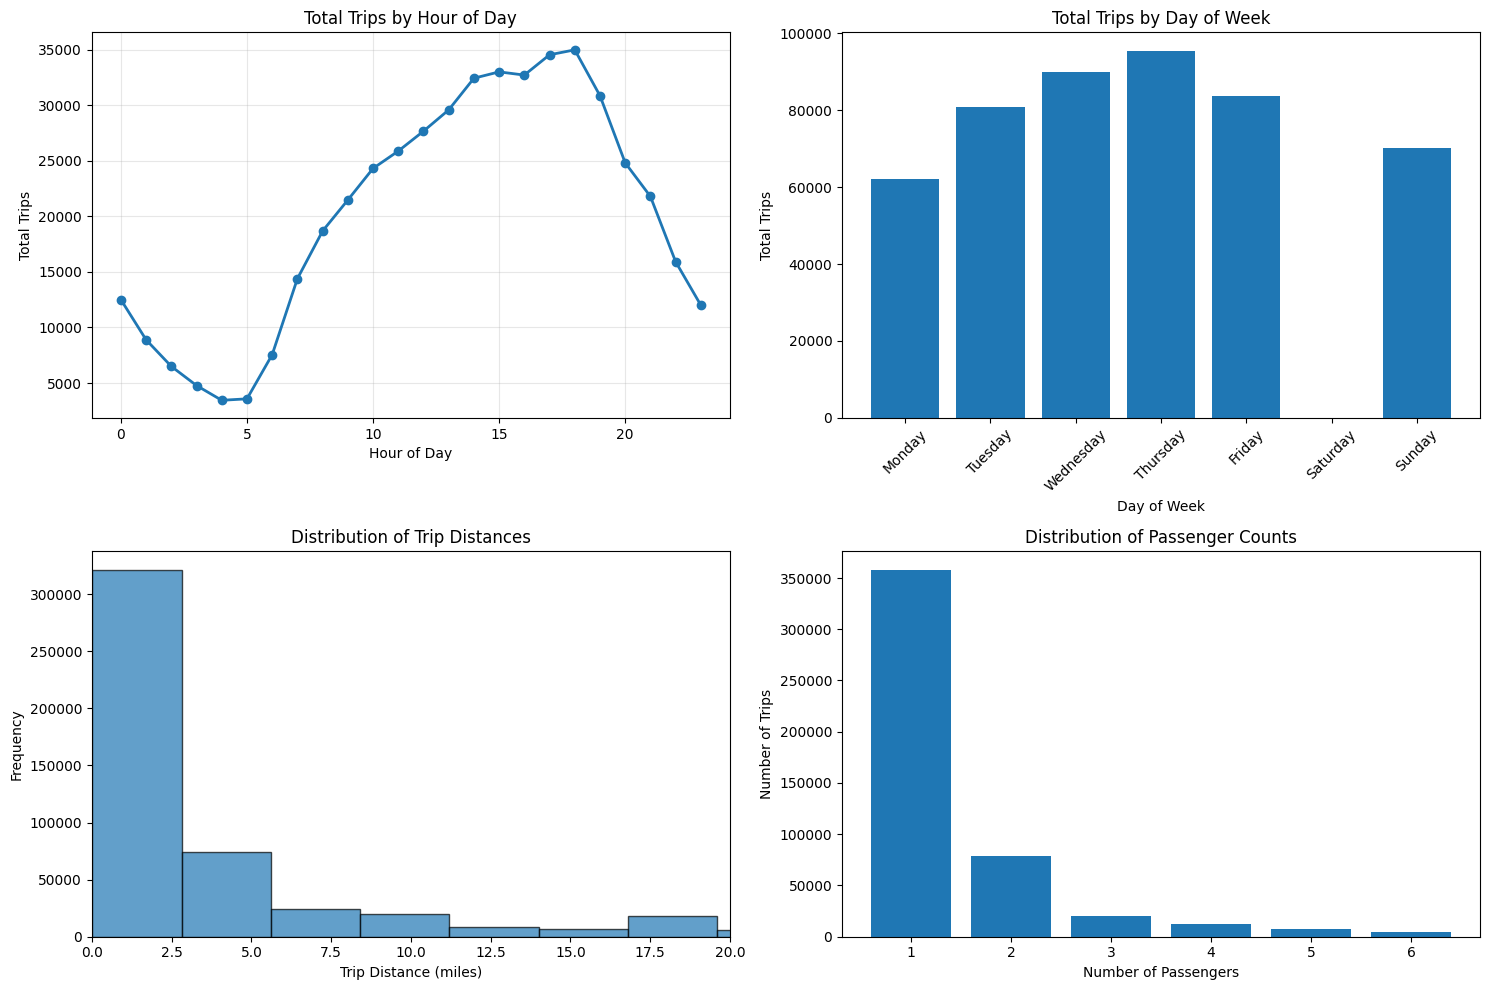

In [6]:
# Temporal patterns analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Hourly demand pattern
hourly_demand = demand_hourly.groupby('hour_of_day')['trip_count'].sum()
axes[0, 0].plot(hourly_demand.index, hourly_demand.values, marker='o', linewidth=2)
axes[0, 0].set_title('Total Trips by Hour of Day')
axes[0, 0].set_xlabel('Hour of Day')
axes[0, 0].set_ylabel('Total Trips')
axes[0, 0].grid(True, alpha=0.3)

# Daily demand pattern - handle missing days
daily_demand = demand_hourly.groupby('day_of_week')['trip_count'].sum()
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create array with zeros for all 7 days, then fill in actual values
daily_values = np.zeros(7)
for day_idx, count in daily_demand.items():
    daily_values[int(day_idx)] = count

axes[0, 1].bar(range(7), daily_values)
axes[0, 1].set_title('Total Trips by Day of Week')
axes[0, 1].set_xlabel('Day of Week')
axes[0, 1].set_ylabel('Total Trips')
axes[0, 1].set_xticks(range(7))
axes[0, 1].set_xticklabels(day_names, rotation=45)

# Trip distance distribution
axes[1, 0].hist(df_clean['trip_distance'], bins=50, alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Distribution of Trip Distances')
axes[1, 0].set_xlabel('Trip Distance (miles)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_xlim(0, 20)  # Focus on reasonable range

# Passenger count distribution
passenger_counts = df_clean['passenger_count'].value_counts().sort_index()
axes[1, 1].bar(passenger_counts.index, passenger_counts.values)
axes[1, 1].set_title('Distribution of Passenger Counts')
axes[1, 1].set_xlabel('Number of Passengers')
axes[1, 1].set_ylabel('Number of Trips')

plt.tight_layout()
plt.show()

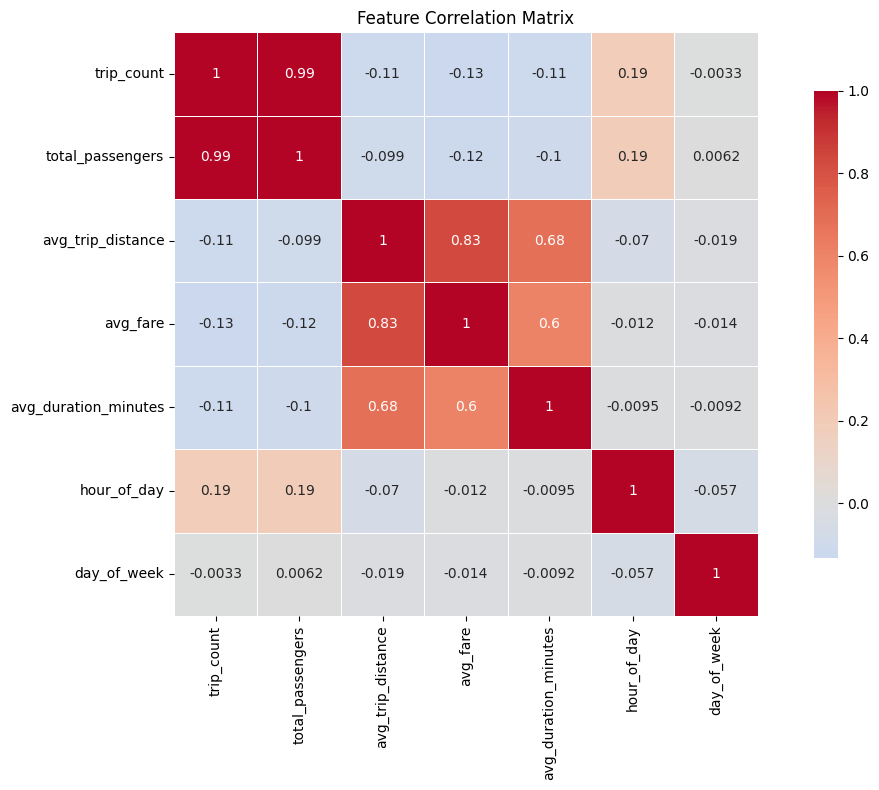

Top 10 locations by total trip volume:
             total_trips  avg_trips_per_hour  trips_std  avg_distance  \
location_id                                                             
132                32949              222.63     136.52         15.16   
237                23139              166.47     137.04          2.23   
236                22853              165.60     144.74          2.71   
161                20972              146.66     127.38          3.50   
186                17833              124.71      75.95          2.69   
138                17423              129.06      87.58          9.32   
162                17344              123.01      92.57          3.05   
142                15595              107.55      78.87          2.96   
230                14587              102.73      71.17          4.21   
170                14215              100.11      70.98          2.98   

             avg_fare  
location_id            
132             58.38  
237         

In [7]:
# Correlation analysis between features
plt.figure(figsize=(12, 8))

# Select numeric columns for correlation analysis
correlation_features = ['trip_count', 'total_passengers', 'avg_trip_distance', 
                       'avg_fare', 'avg_duration_minutes', 'hour_of_day', 'day_of_week']

correlation_matrix = demand_hourly[correlation_features].corr()

# Create heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Summary statistics by location
location_stats = demand_hourly.groupby('location_id').agg({
    'trip_count': ['sum', 'mean', 'std'],
    'avg_trip_distance': 'mean',
    'avg_fare': 'mean'
}).round(2)

location_stats.columns = ['total_trips', 'avg_trips_per_hour', 'trips_std', 
                         'avg_distance', 'avg_fare']

print("Top 10 locations by total trip volume:")
print(location_stats.sort_values('total_trips', ascending=False).head(10))